# 0 Imports

In [1]:
import numpy          as np
import pandas         as pd
import seaborn        as sns
import plotly.express as px

import re
import datetime
import warnings
import inflection

from datetime             import datetime
from matplotlib           import pyplot as plt
from matplotlib.gridspec  import GridSpec
from IPython.display      import Image
from IPython.core.display import HTML

from umap.umap_            import UMAP
from sklearn.cluster       import KMeans
from sklearn.metrics       import silhouette_score  
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster   import KElbowVisualizer,SilhouetteVisualizer

warnings.filterwarnings( 'ignore' )

## 0.1 Funções auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [14, 5]
    plt.rcParams['font.size'] = 18
    sns.set_palette("Reds") 
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Carregamento dos dados

In [4]:
df_raw = pd.read_csv('../inputs/data.csv', encoding= 'unicode_escape')

In [5]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
400940,571408,22972,CHILDREN'S SPACEBOY MUG,2,10/17/2011 12:22,1.65,15012.0,United Kingdom
418178,572703,22130,PARTY CONE CHRISTMAS DECORATION,12,10/25/2011 14:35,0.85,16110.0,United Kingdom
310634,564191,20992,JAZZ HEARTS PURSE NOTEBOOK,1,8/23/2011 16:16,0.39,17315.0,United Kingdom
12716,537393,22441,GROW YOUR OWN BASIL IN ENAMEL MUG,24,12/6/2010 13:59,2.10,13089.0,United Kingdom
424702,573280,23486,ANTIQUE HEART SHELF UNIT,1,10/28/2011 13:42,16.65,14221.0,United Kingdom
207818,555009,21175,GIN + TONIC DIET METAL SIGN,12,5/31/2011 10:32,2.55,17340.0,United Kingdom
72378,542241,21080,SET/20 RED RETROSPOT PAPER NAPKINS,2,1/26/2011 14:51,0.85,16409.0,United Kingdom
180534,552325,23199,JUMBO BAG APPLES,20,5/9/2011 9:47,2.08,12490.0,France
76656,542634,22291,HANGING CHICK CREAM DECORATION,24,1/31/2011 10:42,1.45,15448.0,United Kingdom
175770,551984,22684,FRENCH BLUE METAL DOOR SIGN 9,10,5/5/2011 14:37,1.25,15841.0,United Kingdom


# 1 Descrição dos dados

In [6]:
df1 = df_raw.copy()

## 1.1 Renomeando colunas

In [7]:
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, df1.columns))

#rename
df1.columns = cols_new

## 1.2 Dimensão dos dados

In [8]:
print('Núm de Linhas: {}'.format(df1.shape[0]))
print('Núm de Colunas: {}'.format(df1.shape[1]))

Núm de Linhas: 541909
Núm de Colunas: 8


## 1.3 Tipo dos dados

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Checagem de valores nulos

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Preenchimento de nulos

In [11]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Percentual de dados removidos: {:.2f}%'.format((1 - (df1.shape[0] / df_raw.shape[0]))*100))
print(df1.shape)

Percentual de dados removidos: 24.93%
(406829, 8)


## 1.6 Mudando tipo dos dados

In [12]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], infer_datetime_format=True).dt.date.astype('datetime64')

# customer_id 
df1['customer_id'] = df1['customer_id'].astype('int64').astype('object')

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id             object
country                 object
dtype: object

## 1.7 Análise descritiva

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [15]:
num_attributes.columns

Index(['quantity', 'unit_price'], dtype='object')

In [16]:
cat_attributes.columns

Index(['invoice_no', 'stock_code', 'description', 'customer_id', 'country'], dtype='object')

## 1.7.1 Atributos númericos

In [17]:
# Central Tendency - mean, mediana, 25%, 75% // dispersion - std, min, max, 
ctd1 = num_attributes.describe()

#dispersion - range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#join
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']


medidas

,attributes,count,mean,std,min,25%,median,75%,max,range,skew,kurtosis
0,quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0,161990.0,0.182663,94317.563673
1,unit_price,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0,38970.0,452.219019,246924.542988


### 1.7.1.1 Investigação dos atributos categóricos

1. Quantity negativa (devolução?)
2. Preço unitário = 0 (promoção?)

## 1.7.2 Atributos categóricos

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

invoice_no     22190
stock_code      3684
description     3896
customer_id     4372
country           37
dtype: int64

### Invoice No

In [19]:
# problema: Temos invoice_no com caracteres e números
# df1['invoice_no'].astype('int')

# identificacao:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

print('Número total de invoices com caracteres: {}'.format(len(df_letter_invoices)))
print('Número total de invoices com caracteres e qtd negativa: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Número total de invoices com caracteres: 8905
Número total de invoices com caracteres e qtd negativa: 8905


### Stock Code

In [20]:
# checando stock code so com caracteres
print(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique())

# acao:
## 1. Remover stock code in ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']

['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']


### Description

In [21]:
# acao:
## 1. Deletar coluna de descrição

### Country

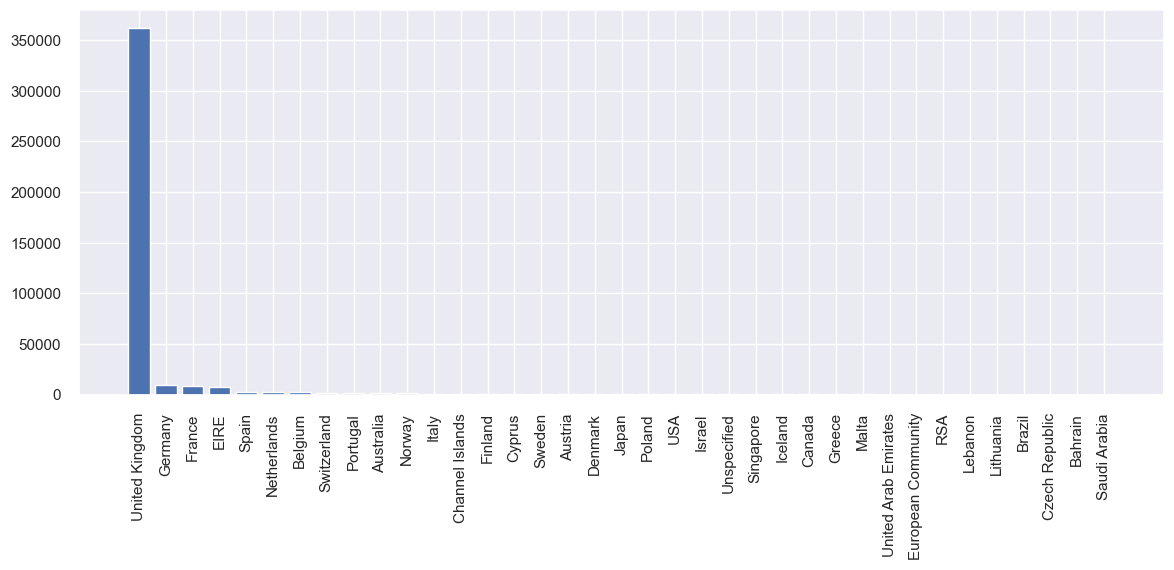

37
United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA    

In [22]:
cat_country = cat_attributes.groupby('country')['invoice_no'].count().reset_index().sort_values('invoice_no', ascending=False)
plt.bar(x=cat_country['country'], height=cat_country['invoice_no'])
plt.xticks(rotation = 90) 
plt.show()


print(len(df1['country'].unique()))
print(df1['country'].value_counts(normalize=True))

# 2 Filtragem dos dados

In [23]:
df2 = df1.copy()

## 2.1 Filtragem das colunas

In [24]:
# description
df2 = df2.drop(columns=['description'])

## 2.2 Filtragem das linhas

In [25]:
# unit_price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK'])]

# country
df2 =  df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3 Feature engineering

In [26]:
df3 = df2.copy()

## 3.1 Criação de novas variáveis

In [27]:
# df de referência 
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)

In [28]:
# revenue = quantity * price
df2_purchases['revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# monetary
df_monetary = df2_purchases.groupby('customer_id')['revenue'].sum().reset_index()

# recency
df_recency = df2_purchases.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days

# frequency
df_frequency = df2_purchases.groupby('customer_id')['invoice_no'].nunique().reset_index()

# Ticket médio
df_avg_ticket = df2_purchases.groupby('customer_id')['revenue'].mean().round(2).reset_index().rename(columns={'revenue': 'avg_ticket'})

In [29]:
# join
c_id = 'customer_id'
df_ref = (df_ref
                .merge(df_monetary, on=c_id, how='left') 
                .merge(df_recency, on=c_id, how='left') 
                .merge(df_frequency, on=c_id, how='left') 
                .merge(df_avg_ticket, on=c_id, how='left'))

In [30]:
print(df_ref.shape)
df_ref.isna().sum()

(4366, 6)


customer_id      0
revenue         33
invoice_date    33
recency_days    33
invoice_no      33
avg_ticket      33
dtype: int64

In [31]:
df_ref.head().T

,0,1,2,3,4
customer_id,17850,13047,12583,13748,15100
revenue,5391.21,3237.54,7281.38,948.25,876.0
invoice_date,2010-12-02 00:00:00,2011-11-08 00:00:00,2011-12-07 00:00:00,2011-09-05 00:00:00,2011-01-10 00:00:00
recency_days,372.0,31.0,2.0,95.0,333.0
invoice_no,34.0,10.0,15.0,5.0,3.0
avg_ticket,18.15,18.82,29.48,33.87,292.0


# 4. Análise exploratória de dados (EDA)

In [32]:
df4 = df_ref.dropna()

# 5 Preparação dos dados

In [37]:
df5 = df4.copy()

## 5.1 Standard Scaler

In [38]:
ss = StandardScaler()

df5['revenue_scaled'] = ss.fit_transform(df5[['revenue']])
df5['recency_days_scaled'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no_scaled'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket_scaled'] = ss.fit_transform(df5[['avg_ticket']])

# 6 Seleção de variáveis

In [39]:
df6 = df5.copy()

# 7 Otimização dos hiperparâmetros

In [40]:
df7 = df6.copy()

In [41]:
X = df7[['revenue_scaled', 'recency_days_scaled', 'invoice_no_scaled', 'avg_ticket_scaled']]

In [42]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

## 7.1 Within-Cluster Sum of Square (WSS)

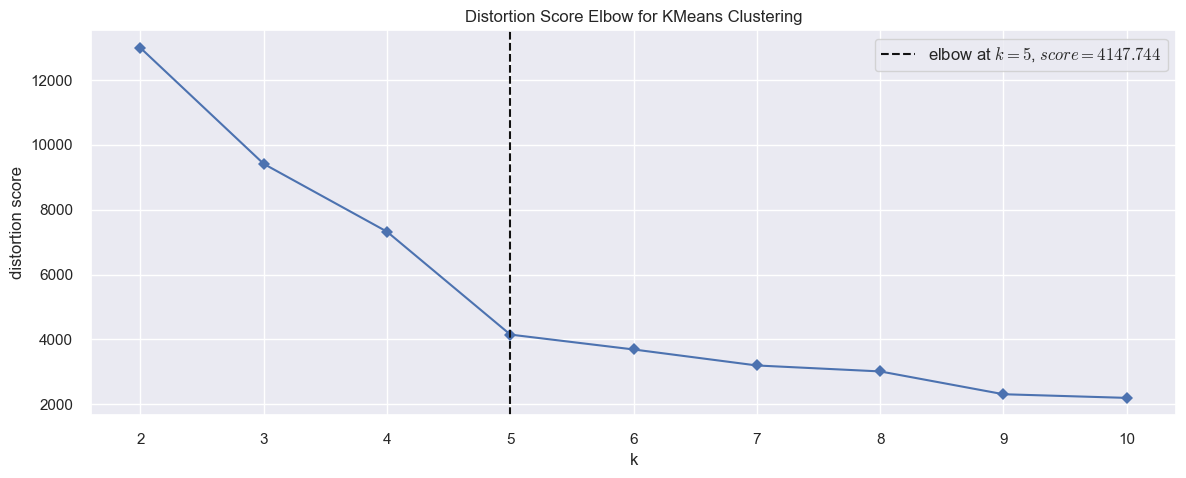

In [43]:
kmeans = KElbowVisualizer(KMeans(init='random', n_init=10, max_iter=300, random_state=42), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

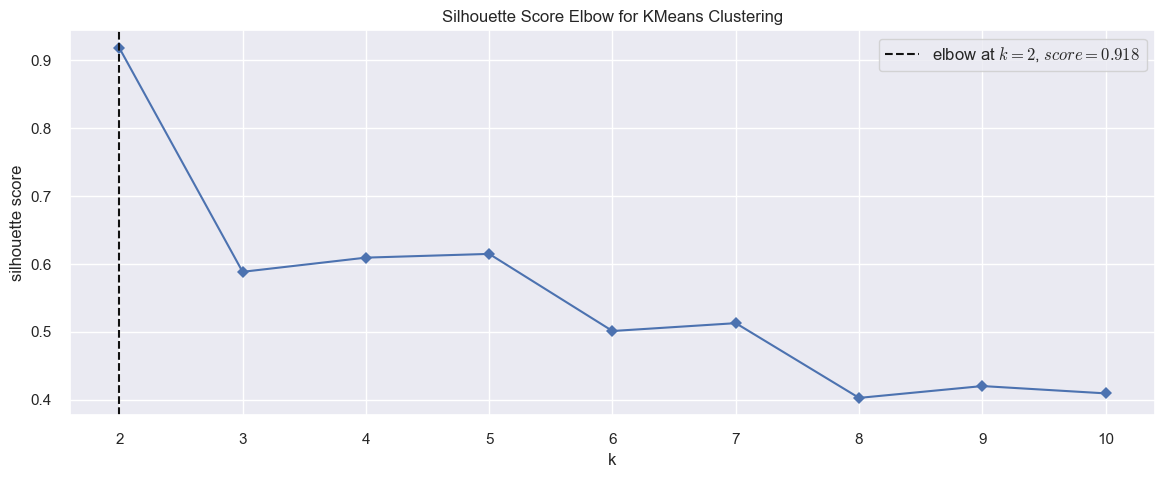

In [44]:
kmeans = KElbowVisualizer(KMeans(init='random', n_init=10, max_iter=300, random_state=42), k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 Análise da silhouette

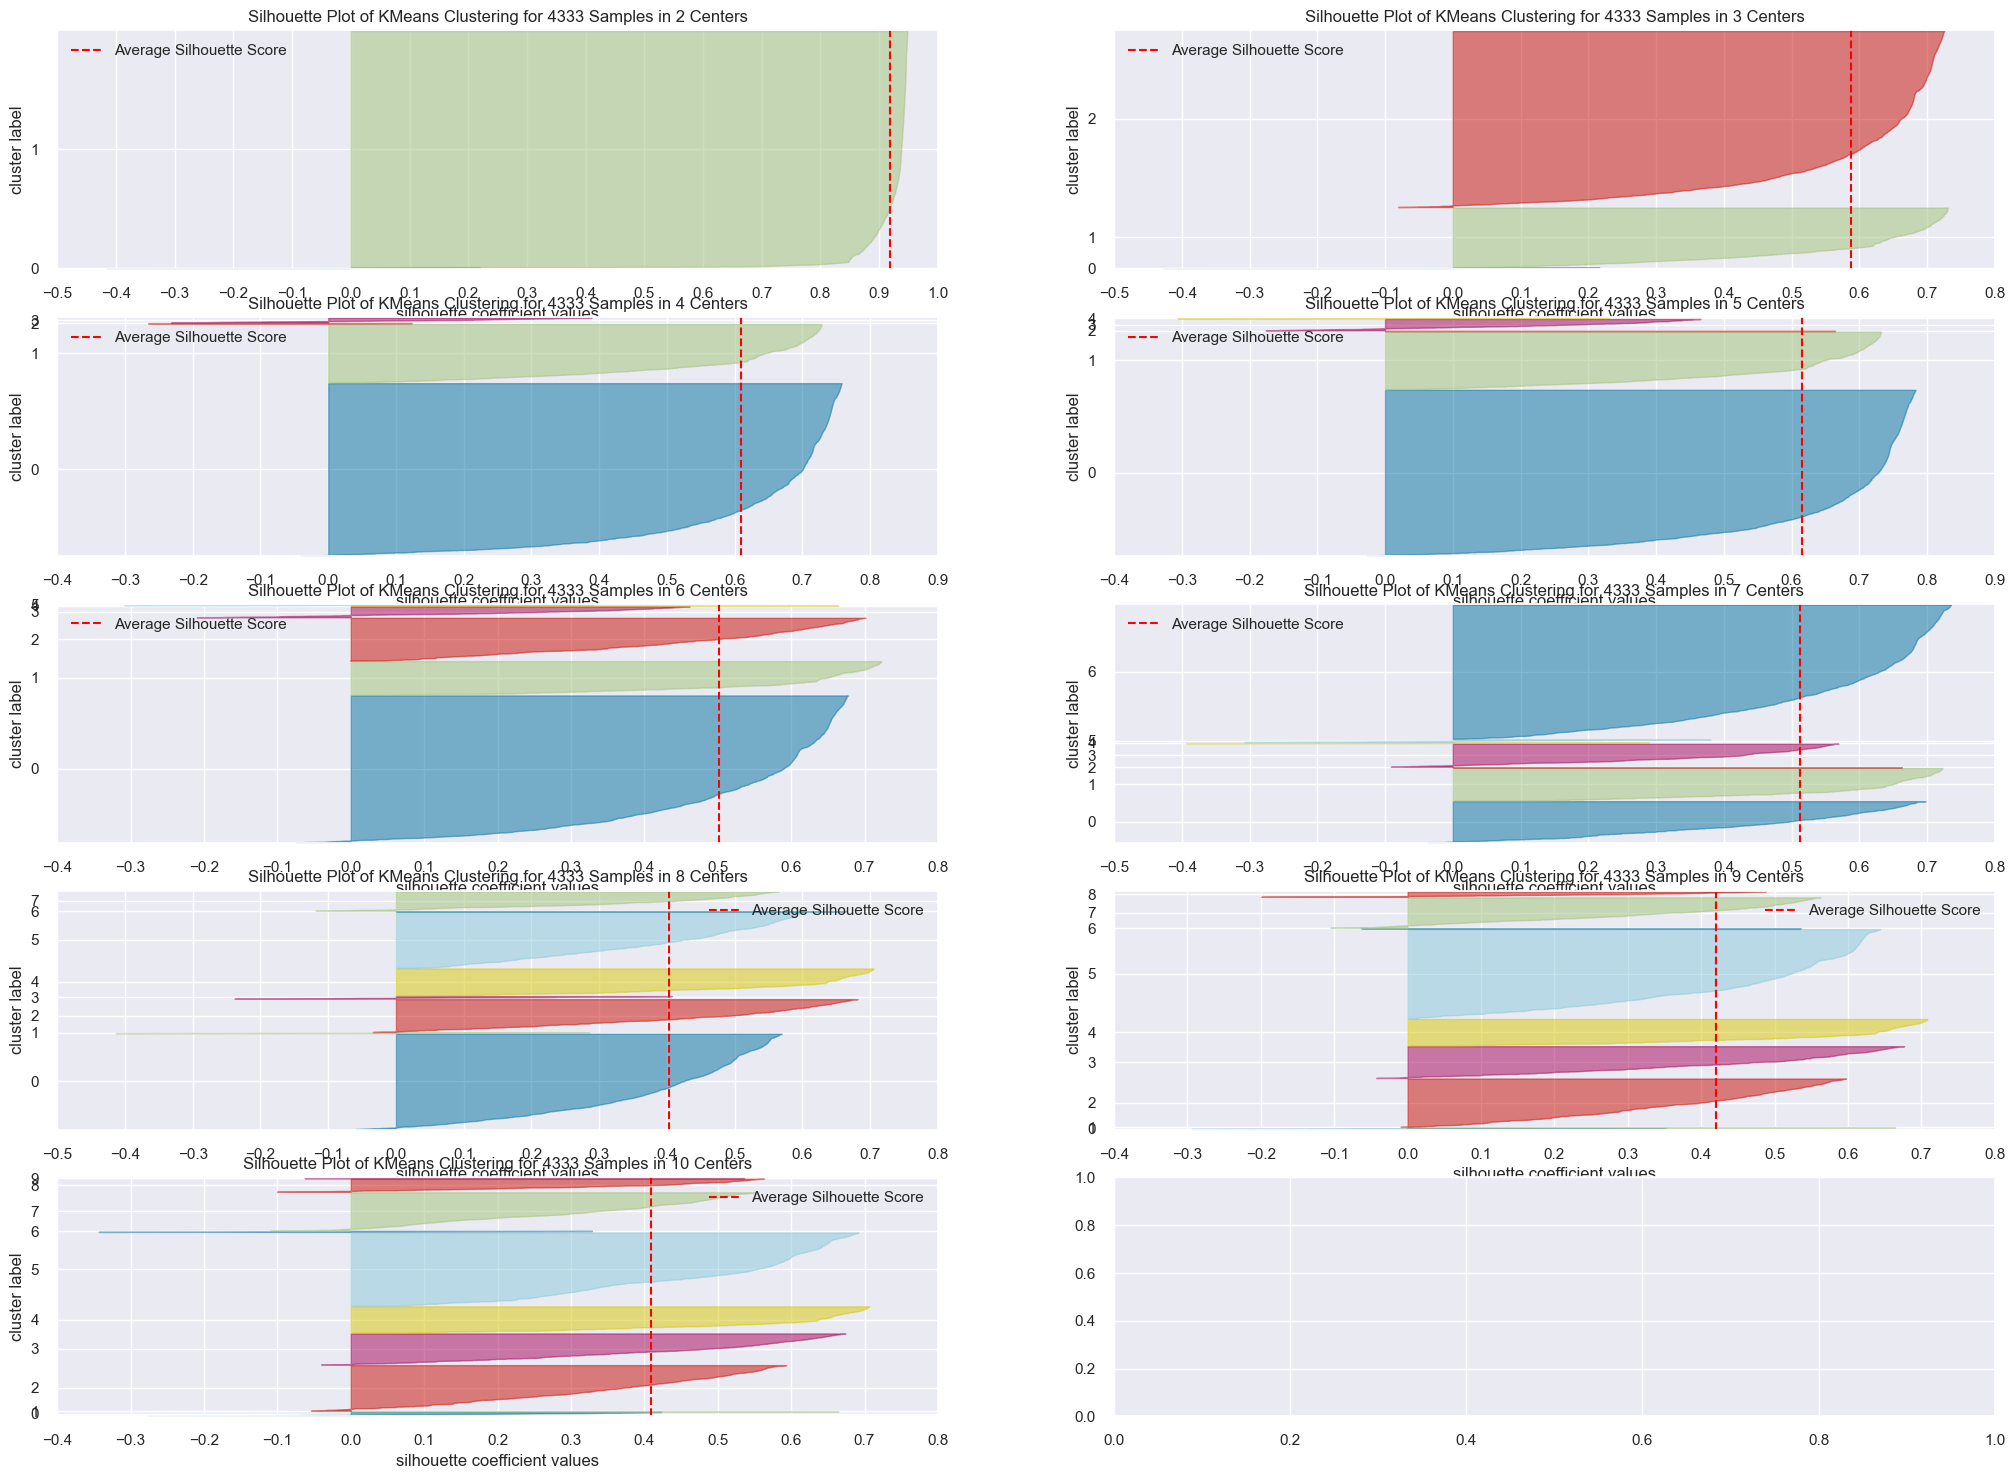

In [45]:
fix, ax = plt.subplots(5, 2, figsize=(25,18))

for k in clusters:
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])   
    visualizer.fit(X)
    visualizer.finalize()

# 8 Machine learning

## 8.1 K-Means

In [46]:
k = 5
#model definition
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2 Validação dos clusters

In [48]:
# WSS (Within-cluster Sum of Square) 
print('WSS Value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS Value: {}'.format(silhouette_score(X, labels)))

WSS Value: 4147.744480290913
SS Value: 0.6149374573449384


# 9 Análise dos clusters

In [49]:
df9 = df7.drop('invoice_date', axis=1).copy()
df9['cluster'] = labels

## 9.1 Inspeção visual

In [45]:
# fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='revenue', color='cluster')
# fig.show()

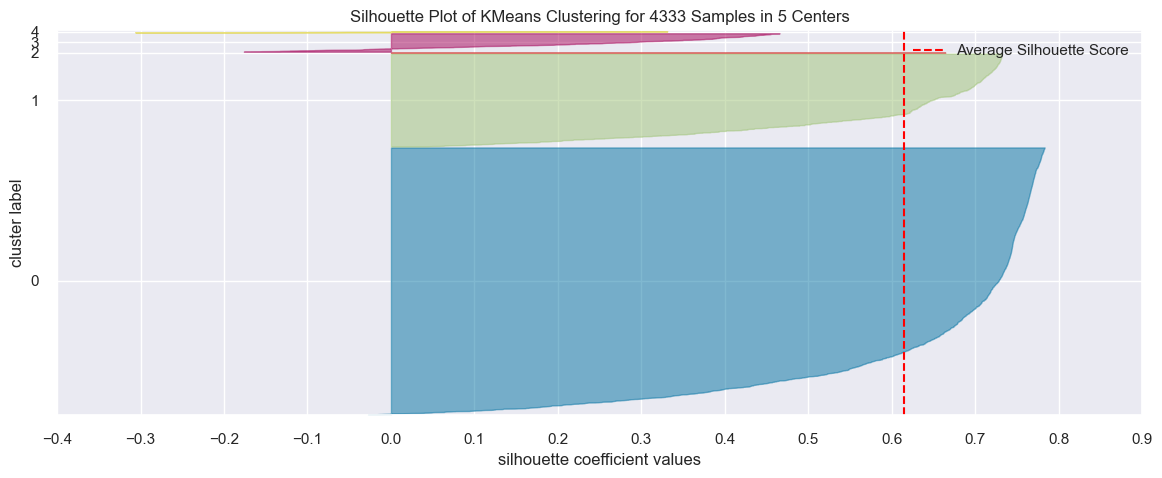

In [50]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')   
visualizer.fit(X)
visualizer.finalize()

## 9.2 2D plot

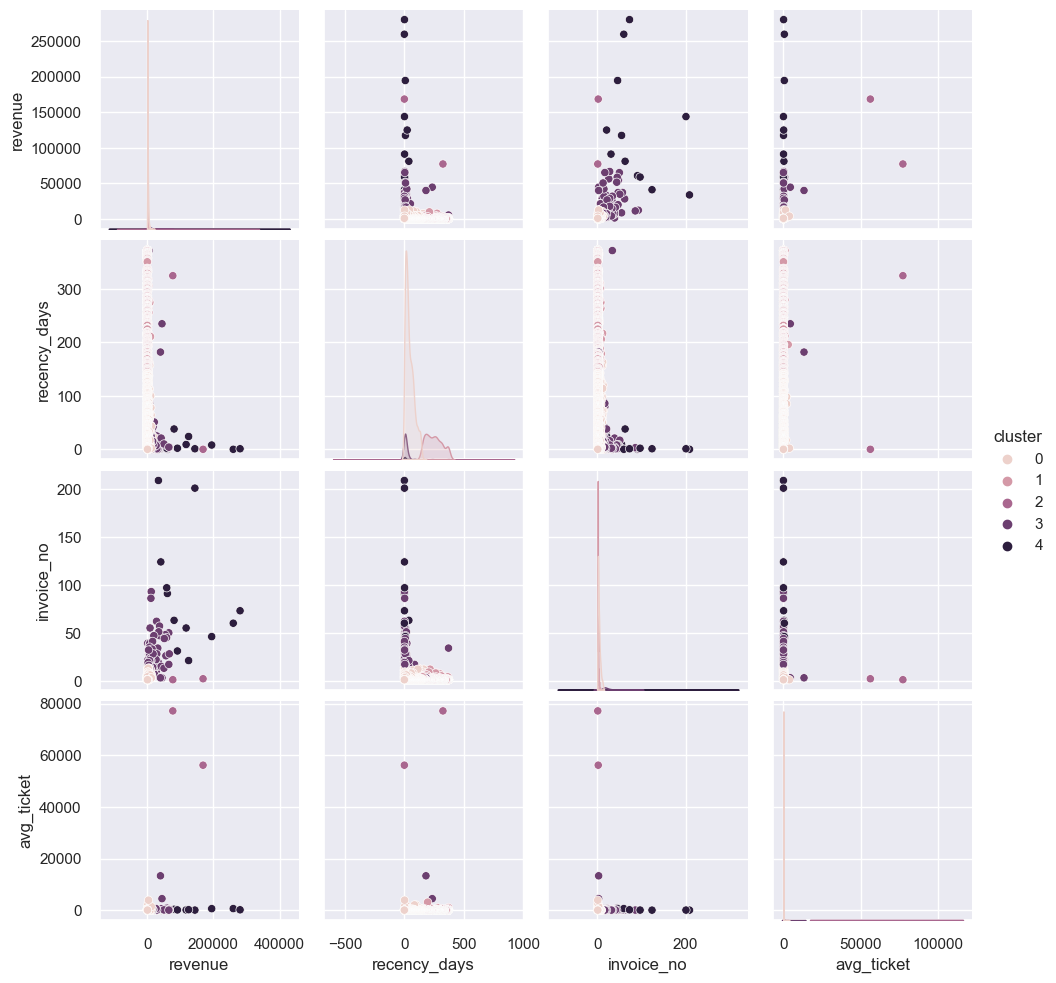

In [55]:
df_viz = df9.drop(columns=['customer_id', 'revenue_scaled', 'recency_days_scaled', 'invoice_no_scaled', 'avg_ticket_scaled'], axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

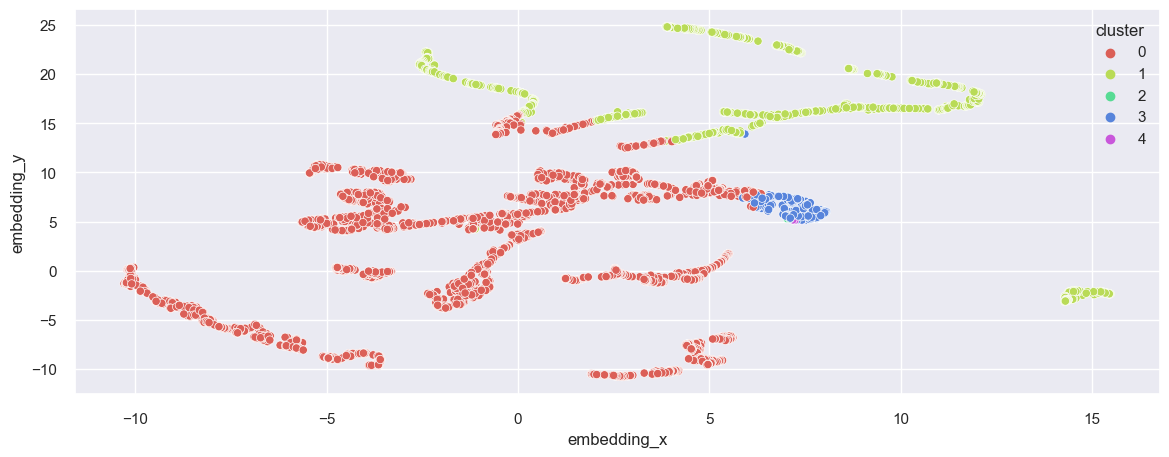

In [52]:
reducer = UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_viz,
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())))

## 9.4 Perfil dos clusters

In [54]:
# Numeros de clientes
df_cluster = df9.groupby('cluster')['customer_id'].count().reset_index()
df_cluster['perc_customer'] = round((df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100, 2)

# Média de faturamento
df_avg_revenue = df9.groupby('cluster')['revenue'].mean().round(2).reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, how='inner', on='cluster')

# Média de recencia
df_avg_recency = df9.groupby('cluster')['recency_days'].mean().round(2).reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Média de frequencia
df_avg_frequency = df9.groupby('cluster')['invoice_no'].mean().round(2).reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

# Ticket médio
df_avg_ticket = df9.groupby('cluster')['avg_ticket'].mean().round(2).reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster.sort_values('customer_id')

,cluster,customer_id,perc_customer,revenue,recency_days,invoice_no,avg_ticket
2,2,2,0.05,122828.05,162.50,1.50,66670.55
4,4,12,0.28,123910.47,7.17,89.25,174.89
3,3,211,4.87,12115.39,13.59,22.10,137.22
1,1,1060,24.46,477.67,248.25,1.55,36.25
0,0,3048,70.34,1349.14,43.40,3.65,30.71


### Cluster 01: Candidato ao programa Insider
- Número de clientes: 6 (0,14% do total da base)
- Recência média: 7 dias
- Compras média no período: 89 compras
- Receita média: $182.181

- Ticket médio: $162,86

### Cluster 02:
- Número de clientes: 28 (0,64% do total da base)
- Recência média: 6 dias
- Compras média no período: 57 compras
- Receita média: $42.614

- Ticket médio: $162,86

### Cluster 03:
- Número de clientes: 267 (6,11% do total da base)
- Recência média:20 dias
- Compras média no período: 19 compras
- Receita média: $8.089

- Ticket médio: $62,78

### Cluster 04:
- Número de clientes: 4071 (93,12% do total da base)
- Recência média: 97 dias
- Compras média no período: 4 compras
- Receita média: $946

- Ticket médio: $25,35

# 10 Deployment do modelo em produção